In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
# import myIRLS function, originally from von Freyburg et al., (2018) and translated from R to python
from myIRLS import myIRLS,sincosfit

plt.rcParams.update({'font.size': 15,
                    'axes.labelsize': 16,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16})
# read in my plot parameters
pp = pd.read_csv('plotparams.csv',index_col=0)

# Notebook 2: isotope data analysis and young water fractions (F$_{\mathrm{yw}}$)

This notebook performs calculations on stable isotope (O and H) data for streamflow and precipitation in the Luquillo Mountains. We evaluate d-excess as a conservative tracer and specifically determine whether evaporation may significantly bias results. The young water fraction (F$_{\mathrm{yw}}$) is computed from the amplitudes of sinusoidal fits to variation in precipitation and streamflow d-excess over time. 

In [2]:
# read in discharge-matched data from WRR2025_compile
luqdf = pd.read_csv('data/WRR2025_cq_sp.csv',index_col=0,parse_dates=['datetime','datetime_last'])
# read in site info (using elevation mainly)
siteinfo = pd.read_csv('data/WRR2025_siteinfo.csv',index_col=0)
# read in discharge medians
df_medians = pd.read_csv('data/WRR2025_discharge_medians.csv',index_col=0)

In [3]:
# Rainfall isotopes" Table 2 from Scholl et al., 2014 USGS Data Publication, also described in Scholl and Murphy, (2014)
scholldf = pd.read_excel('downloaded/USGS_OFR2014-1101_Table2.xlsx',parse_dates=['Collection date and time'],na_values=['---','--','-- '],skiprows=[0,1,2,3,4,5,6,7])
scholldf.columns = ['Site','datetime','Sample volume (mm)','d2H','d18O','comment']
scholldf['dexcess'] = scholldf['d2H']-8*scholldf['d18O']
schollelevations = {'LQR3': 625,
                   'LQR4': 1011,
                   'LQR5a': 2,
                   'LQR5b': 5,
                   'LQR6': 502} # from  Table 1 of Scholl et al., 2014 USGS Data Publication

In [4]:
# useful functions
def time2float(stamp):
    year = stamp.year
    if year % 4 != 0 or (year % 100 == 0 and year % 400 != 0): # long boolean to get non-leap ears
        output = stamp.year+(stamp.month-1)/12 + (stamp.day-1)/365+(stamp.hour-1)/8760
    else:
        output = stamp.year+(stamp.month-1)/12 + (stamp.day-1)/366+(stamp.hour-1)/8760
    return output#-start

### these are functions relating elevation to precipitaiton d-excess
### from dD and dO lapse rates reported in Scholl et al., 2014

def tradewind(z):
    tempD = -0.005*z+7.188
    tempO = -0.0011*z-0.918
    return [tempO,tempD]

def convect(z):
    tempD = -0.0069*z-14.82
    tempO = -0.0013*z-3.148
    return [tempO,tempD]

def tradewind_dxs(z):
    [tempO,tempD] = tradewind(z)
    tempDexcess = tempD-8*tempO
    return tempDexcess

def convect_dxs(z):
    [tempO,tempD] = convect(z)
    tempDexcess = tempD-8*tempO
    return tempDexcess
    
def gmwl(do):
    return do*8+10

def lmwl(do):
    return do*8.2 + 14

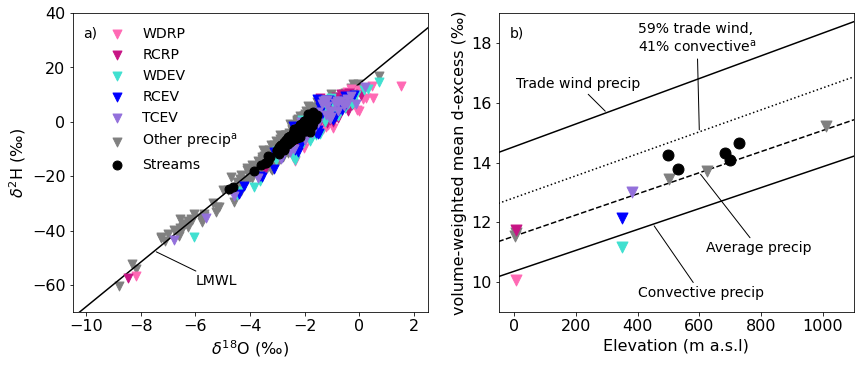

In [5]:
### make isotope biplot and elevation plot
fig,ax = plt.subplots(1,2,figsize=(14,5.5))

plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 16,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16})
# axis labels 16

# sites at El Verde
elverdelist = ['WDEV','RCEV','TCEV']
# all sites measured in this study (El Verde and Rio Piedras)
preciplist = ['WDRP','RCRP','WDEV','RCEV','TCEV']
# precip sites from previous study
otherlist = ['LQR3','LQR4','LQR5a','LQR5b','LQR6']
# stream sites
streamsitelist = ['RI','QG','I0','QS','QP','RESSH','MPR','Q3']

# initialize mean table 
meantable = pd.DataFrame(index=['','Precipitation']+preciplist+['Streamflow']+streamsitelist)
meantable_other = pd.DataFrame(index=otherlist)


precip_fitx = []
precip_fity = []

psize1 = 80
psize2 = 120

# plot isotope biplot and compute volume-weighted annual mean for each site
for s in preciplist:
    tempdf = luqdf[luqdf['site']==s]
    tempdf = tempdf[~np.isnan(tempdf['dexcess'])]

    label=s
    
    ax[0].scatter(tempdf['d18O'],tempdf['d2H'],c=pp.color[s],marker='v',label=label,s=psize1)
    
    # group by month first to avoid weighting by season
    tempdf['month'] = [i.month for i in tempdf['datetime']]
    
    if s in ['RCEV','WDEV','TCEV']: # weight by rainfall (mm) from El Verde rainfall collector data
        monthlyamounts = tempdf[['rainfall(mm)','month']].groupby('month').sum().values
    else: # WDRP and RCRP from USGS collector, rainfall in inches (units dont matter because just used for weighting)
        monthlyamounts = tempdf[['rainfall(in)','month']].groupby('month').sum().values
        
    for isotope in ['d18O','d2H','dexcess']:
        meantable.loc[s,isotope+'_avg'] = np.nanmean(tempdf[isotope]) # save to mean table
        
        monthlyval = tempdf[[isotope,'month']].groupby('month').mean().values
        volumeweights = monthlyamounts/np.nansum(monthlyamounts)
        volumemean = np.nansum([i*j for i,j in zip(monthlyval,volumeweights)]) # volume-weighted mean for every month
        meantable.loc[s,isotope+'_vwavg'] = volumemean

    ax[1].scatter(siteinfo.loc[s,'elevation'],meantable.loc[s,'dexcess_vwavg'],c=pp.color[s],marker='v',s=psize2,zorder=2)
    
    if s in ['RCEV','RCRP','TCEV']:
        precip_fitx.append(siteinfo.loc[s,'elevation'])
        precip_fity.append(meantable.loc[s,'dexcess_vwavg'])
    
for s in otherlist:
    if s==otherlist[0]:
        label = 'Other precip$^{\mathrm{a}}$'
    else:
        label = '_nolegend_'
    tempdf = scholldf[scholldf['Site']==s]
    tempdf = tempdf[~np.isnan(tempdf['dexcess'])]
    
    ax[0].scatter(tempdf['d18O'],tempdf['d2H'],c='gray',marker='v',zorder=0,label=label,s=psize1)
    
    # group by month first to avoid weighting by season
    tempdf['month'] = [i.month for i in tempdf['datetime']]
    
    # monthly volume
    monthlyamounts = tempdf[['Sample volume (mm)','month']].groupby('month').sum().values

    volumeweights = monthlyamounts/np.nansum(monthlyamounts)
    volumemean = np.nansum([i*j for i,j in zip(monthlyval,volumeweights)])
    
    for isotope in ['d18O','d2H','dexcess']:
        meantable_other.loc[s,isotope+'_avg'] = np.nanmean(tempdf[isotope]) # save to mean table
        
        monthlyval = tempdf[[isotope,'month']].groupby('month').mean().values
        volumeweights = monthlyamounts/np.nansum(monthlyamounts)
        volumemean = np.nansum([i*j for i,j in zip(monthlyval,volumeweights)]) # volume-weighted mean for every month
        meantable_other.loc[s,isotope+'_vwavg'] = volumemean

    
    ax[1].scatter(schollelevations[s],volumemean,c='gray',marker='v',zorder=1,s=psize2)
  
    precip_fitx.append(schollelevations[s])
    precip_fity.append(volumemean)

for s in streamsitelist:
    if s==streamsitelist[0]:
        label='Streams'
    else:
        label = '_nolegend_'
    
    tempdf = luqdf[luqdf['site']==s]
    
    tempdf = tempdf[~np.isnan(tempdf['dexcess'])]
    
    ax[0].scatter(tempdf['d18O'],tempdf['d2H'],c='k',s=psize1,label=label)
        
    # plot time-weighted mean dexcess
    tempdf['month'] = [i.month for i in tempdf['datetime']]
    
    # monthly volume    
    monthlyamounts = tempdf[['discharge(m/yr)','month']].groupby('month').mean().values

    for isotope in ['d18O','d2H','dexcess']:
        meantable.loc[s,isotope+'_avg'] = np.nanmean(tempdf[isotope]) # save to mean table
    
        monthlyval = tempdf[[isotope,'month']].groupby('month').mean().values
        volumeweights = monthlyamounts/np.nansum(monthlyamounts)
        volumemean = np.nansum([i*j for i,j in zip(monthlyval,volumeweights)])
        
        if volumemean==0: # some sites no discharge
            meantable.loc[s,isotope+'_vwavg'] = np.nan
        else:
            meantable.loc[s,isotope+'_vwavg'] = volumemean
    
    ax[1].scatter(siteinfo.loc[s,'meanelevation'],meantable.loc[s,'dexcess_vwavg'],color='k',s=psize2)

# regress linear relationship between elevation and d-excess
res = scipy.stats.linregress(precip_fitx,precip_fity)
    
# plot LMWL
plotx = np.arange(-11,6)
ax[0].plot(plotx,lmwl(plotx),ls='-',c='black',zorder=0)
ax[0].annotate(xy=[-7.5,lmwl(-7.5)],xytext=[-6,-60],text='LMWL',arrowprops=dict(arrowstyle = '-'))

# plot convective and tradewind d-excess vs. elevation
plotz=np.arange(-100,1300)
ax[1].plot(plotz,[tradewind_dxs(z) for z in plotz],ls='-',c='black',label='_nolegend_',zorder=0)
ax[1].plot(plotz,[convect_dxs(z) for z in plotz],ls='-',c='black',label='_nolegend_',zorder=0)
ax[1].annotate(xy=[300,tradewind_dxs(300)],xytext=[5,16.5],text='Trade wind precip',arrowprops=dict(arrowstyle = '-'))
ax[1].annotate(xy = [450,convect_dxs(450)],xytext=[400,9.5],text='Convective precip',arrowprops=dict(arrowstyle = '-'))

# plot regression of precipitation d-excess vs. elevation for all rain sampling sites
ax[1].plot(plotz,plotz*res.slope+res.intercept,'--',zorder=0,c='black',label='_nolegend_')
ax[1].annotate(xy=[600,600*res.slope+res.intercept],xytext=[620,11],text='Average precip',arrowprops=dict(arrowstyle = '-'))

# plot line for 59% tradewind, 41% convective for baseflow from Scholl et al., 2014 
ax[1].plot(plotz,[convect_dxs(z)*0.41+tradewind_dxs(z)*0.59 for z in plotz],ls=':',c='black',label='_nolegend_',zorder=0)
ax[1].annotate(xy=[600,convect_dxs(600)*0.41+tradewind_dxs(600)*0.59],xytext=[400,17.7],text='59% trade wind,\n41% convective$^{\mathrm{a}}$',arrowprops=dict(arrowstyle = '-'))

# plot limits, labels, legend
ax[0].set_xlim([-10.5,2.5])
ax[0].set_ylim([-70,40])
ax[1].set_xlim([-50,1100])
ax[1].set_ylim([9,19])

ax[0].set_ylabel(r'$\delta^{2}$H (‰)')
ax[0].set_xlabel(r'$\delta^{18}$O (‰)')
ax[1].set_ylabel(u'volume-weighted mean d-excess (‰)')
ax[1].set_xlabel('Elevation (m a.s.l)')

ax[0].legend(loc=[0.07,0.45],frameon=False,fontsize=14,ncol=1)

ax[0].text(0.03,0.92,'a)',transform=ax[0].transAxes)
ax[1].text(0.03,0.92,'b)',transform=ax[1].transAxes)

fig.savefig('plots/Fig3_biplot_elevation.pdf')

In [6]:
# export mean table
meantable.columns = [r'$\delta^{18}$O (‰)','',r'$\delta^{2}$H (‰)','',r'd-excess (‰)','']
meantable.iloc[0,:] = ['unweighted','weighted','unweighted','weighted','unweighted','weighted']
meantable.to_csv('tables/WRR2025_meantable.csv')

<ipython-input-7-aa37cbab3967>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain['month'] = rain['datetime'].dt.month


original amp dxs: 3.6949093582196406 permil
original amp dO: 0.9076584795348467 permil
low E amp dxs: 3.5117657855029116 permil
low E amp dO: 1.0184345203701097 permil
low E amp dxs: 3.461451247154772 permil
low E amp dO: 1.250795007196507 permil


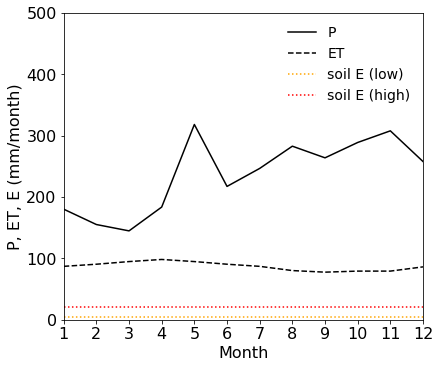

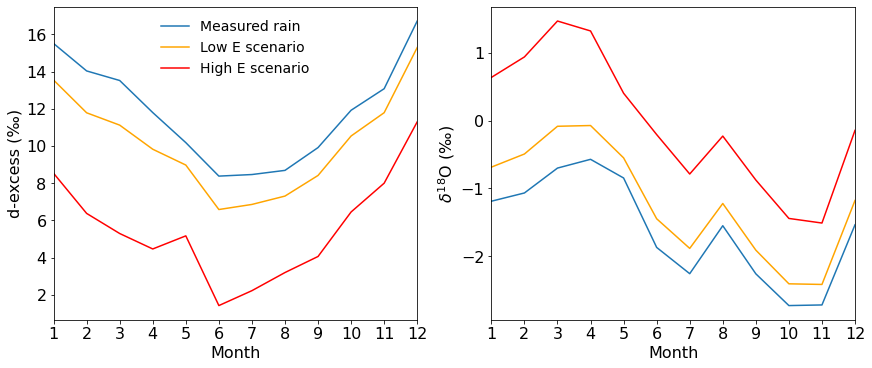

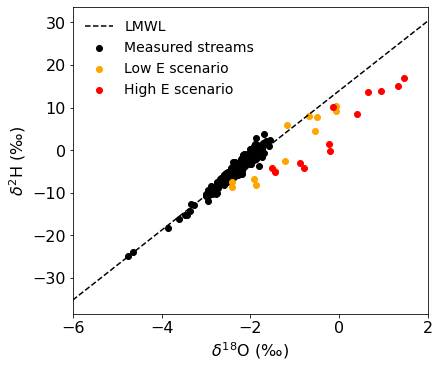

In [7]:
## Supplemental figures: what would happen if ET changed d-excess?
# need monthly P, ET, T, RH
# P and ET from Zhang et al., 2018
# T and RH from El Verde EDI 

# meteterological data form El Verde
infile3  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/127/1676177/08c01f17d967490a05ac097a1b72bde5".strip() 
infile3  = infile3.replace("https://","http://")
                 
metdf =pd.read_csv(infile3      
            ,sep=",",parse_dates=['datetime'],na_values=['?'],low_memory=False)

# Zhang ET data
zhangdf = pd.read_csv('downloaded/Zhang2018_digitized.csv',index_col=0)

# monthly data
metdf['month'] = metdf['datetime'].dt.month
t_m = metdf[['month','AirTC_Avg']].groupby('month').mean().values.T[0]
rh_m = metdf[['month','RH_percent']].groupby('month').mean().values.T[0]
rain = luqdf.loc[luqdf['site']=='RCEV',:]
rain['month'] = rain['datetime'].dt.month
precip_do = rain[['month','d18O']].groupby('month').mean().values.T[0]
precip_dd = rain[['month','d2H']].groupby('month').mean().values.T[0]
precip_dxs = precip_dd-precip_do*8
months = np.arange(1,13)/12

# print original amplitude for monthly d-exces variation
fit,statsdict,data_fit_plot = sincosfit(months,precip_dxs,ww=np.ones(len(precip_dxs)),irls=False)
print(f'original amp dxs: {statsdict["amp"]} permil')
# dO
fit,statsdict,data_fit_plot = sincosfit(months,precip_do,ww=np.ones(len(precip_do)),irls=False)
print(f'original amp dO: {statsdict["amp"]} permil')

# functions from Gibson and Edwards 2002
def epsilonstar_do(t):
    tink = t+273
    return -7.685+6.7123*(1000/tink)-1.664*(1e6/(tink**2))+0.35041*(1e9/(tink**3))

def epsilonstar_dd(t):
    tink = t+273
    return 1158.8*(tink**3 / 1e9)-1620.1*(tink**2 / 1e6) +794.84*(tink/1e3) -161.04+2.9992*(1e9/(tink**3)) 

# Ck constant from Gibson Edwards 2002
Ck_do = 14.2
Ck_dd = 12.5
# epsilon fractionation factors
epsilon_do = epsilonstar_do(t_m)+Ck_do*(1-rh_m/100)
epsilon_dd = epsilonstar_dd(t_m)+Ck_dd*(1-rh_m/100)

# compute other parameters from Gibson Edwards 2002
# isotope composition of atmospheric vapor
atm_do = (precip_do-epsilonstar_do(t_m))/(epsilonstar_do(t_m)*1e-3+1)
atm_dd = precip_dd-epsilonstar_dd(t_m)/(epsilonstar_do(t_m)*1e-3+1)
# limiting isotope composition
star_do = ((rh_m/100)*atm_do+epsilon_do)/(rh_m/100-epsilon_do*1e-3)
star_dd = ((rh_m/100)*atm_dd+epsilon_dd)/(rh_m/100-epsilon_dd*1e-3)
# enrichment slope
m_do = (rh_m/100-epsilon_do*1e-3)/(1-rh_m/100+1e-3*Ck_do*(1-rh_m/100))
m_dd = (rh_m/100-epsilon_dd*1e-3)/(1-rh_m/100+1e-3*Ck_dd*(1-rh_m/100))

# initialize figures
fig,ax = plt.subplots(1,1,figsize=(6,5),constrained_layout=True)
fig2,ax2 = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)
fig3,ax3 = plt.subplots(1,1,figsize=(6,5),constrained_layout=True)

# monthly P, ET
ax.plot(zhangdf['P'],c='k',ls='-')
ax.plot(zhangdf['ET'],c='k',ls='--')
ax.axhline(0.14*30,ls=':',c='orange')
ax.axhline(0.71*30,ls=':',c='red')

# monthly isotopes
ax2[0].plot(np.arange(1,13),precip_dxs)
ax2[1].plot(np.arange(1,13),precip_do)

plotx = np.arange(-6,3)

ax3.plot(plotx,lmwl(plotx),c='k',ls='--')

# plot streams
streams = luqdf.loc[luqdf['site'].isin(streamsitelist),:]
ax3.scatter(streams['d18O'],streams['d2H'],c='k')

# low evaporation case: 0.14 mm/day
x = 0.14*30/zhangdf['P'] # X is the fraction of total inflowing water (I) that is evaporated (E).
l_do = (m_do*star_do*x+precip_do)/(m_do*x+1)
l_dd = (m_dd*star_dd*x+precip_dd)/(m_dd*x+1)
l_dxs = l_dd-l_do*8

ax2[0].plot(np.arange(1,13),l_dxs,c='orange')
ax2[1].plot(np.arange(1,13),l_do,c='orange')
ax3.scatter(l_do,l_dd,c='orange')

# print amplitude for low evaporation case:
# d-excess
fit,statsdict,data_fit_plot = sincosfit(months,l_dxs,ww=np.ones(len(l_dxs)),irls=False)
print(f'low E amp dxs: {statsdict["amp"]} permil')
# do
fit,statsdict,data_fit_plot = sincosfit(months,l_do,ww=np.ones(len(l_do)),irls=False)
print(f'low E amp dO: {statsdict["amp"]} permil')


# high evaporation case: if only 0.71 mm/day, 21.3 mm/month is fractionating (Evaristo 2016)
x = 0.71*30/zhangdf['P']
l_do = (m_do*star_do*x+precip_do)/(m_do*x+1)
l_dd = (m_dd*star_dd*x+precip_dd)/(m_dd*x+1)
l_dxs = l_dd-l_do*8

ax2[0].plot(np.arange(1,13),l_dxs,c='red')
ax2[1].plot(np.arange(1,13),l_do,c='red')
ax3.scatter(l_do,l_dd,c='red')

# print amplitude for high evaporation case:
# dexcess
fit,statsdict,data_fit_plot = sincosfit(months,l_dxs,ww=np.ones(len(l_dxs)),irls=False)
print(f'low E amp dxs: {statsdict["amp"]} permil')
# do
fit,statsdict,data_fit_plot = sincosfit(months,l_do,ww=np.ones(len(l_do)),irls=False)
print(f'low E amp dO: {statsdict["amp"]} permil')


# plot details
ax.set_xlim([1,12])
ax.set_ylim([0,500])
ax.set_xticks(range(1,13))
ax.set_xlabel('Month')
ax.set_ylabel('P, ET, E (mm/month)')

ax2[0].set_xlim([1,12])
ax2[0].set_xticks(range(1,13))
ax2[0].set_xlabel('Month')
ax2[0].set_ylabel('d-excess (‰)')

ax2[1].set_xlim([1,12])
ax2[1].set_xticks(range(1,13))
ax2[1].set_xlabel('Month')
ax2[1].set_ylabel(r'$\delta^{18}$O (‰)')

ax3.set_ylabel(r'$\delta^{2}$H (‰)')
ax3.set_xlabel(r'$\delta^{18}$O (‰)')
ax3.set_xlim([-6,2])

# legends
ax.legend(['P','ET','soil E (low)','soil E (high)'],frameon=False)
ax2[0].legend(['Measured rain','Low E scenario','High E scenario'],frameon=False)
ax3.legend(['LMWL','Measured streams','Low E scenario','High E scenario'],frameon=False)

# save
fig.savefig('plots/FigS4_monthlyPET.pdf')
fig2.savefig('plots/FigS6_evapmonthly.pdf')
fig3.savefig('plots/FigS5_evapLMWL.pdf')

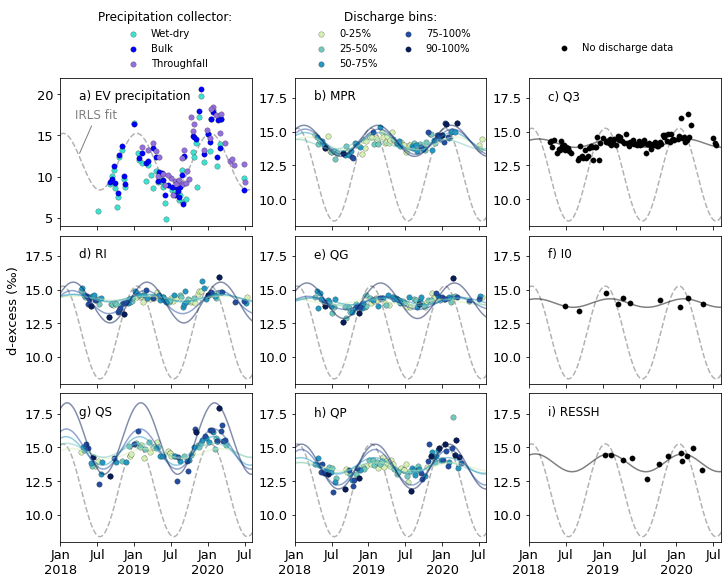

In [8]:
# plot params for big plot

plt.rcParams.update({'font.size': 12,
                    'axes.labelsize': 13,
                    'xtick.labelsize':13,
                    'ytick.labelsize':13})
# axis labels 16
smallps = 30

import matplotlib.cm as cm
cmap = cm.get_cmap('YlGnBu') 
colors = cmap(np.linspace(1/5,1,5))
    
fig3,ax3 = plt.subplots(3,3,figsize=(10,8),constrained_layout=True,sharex=True);
ax3=ax3.flatten();
ax3index = 1 # start at one because 0 already has rainfall


# set isotope to test
isotope = 'dexcess'


# initialize output dfs
outputdf = pd.DataFrame(columns = ['amp','phaseshift','rsquared','sterror'])
perc_outputdf = pd.DataFrame(columns = ['amp','phaseshift','rsquared','sterror'])

# two groups: El Verde and Rio Piedras
luqdf['EVcomp'] = (luqdf['site']=='RCEV') | (luqdf['site']=='TFALL') # composite between rain collector and throughfall collector

precipsitelist = elverdelist+['EVcomp']

streamsitelist = ['MPR','Q3','RI','QG','I0','QS','QP','RESSH']

sitelist = precipsitelist+streamsitelist

dischargebottoms = [0,25,50,75,90]
dischargetops = [25,50,75,100,100]


longt = np.arange(2018,2021,0.01)
data_fit_rain_list = []

for i,s in enumerate(sitelist): # plot individually, sine fit as group
    if s=='EVcomp':
        tempdf = luqdf.loc[luqdf['EVcomp']==True,:]
    else:
        tempdf = luqdf[luqdf['site']==s]

    tempdate = np.array([time2float(i) for i in tempdf['datetime']])
    templast = np.array([time2float(i) for i in tempdf['datetime_last']])

    if s in precipsitelist:
        tempvol = np.array(tempdf['rainfall(mm)'])
        tempdate = np.array([(i+j)/2 for i,j in zip(tempdate,templast)])    

    else:
        tempvol = np.array(tempdf['discharge(m/yr)'])

    if all(np.isnan(tempvol)):
        voldata = False
        tempvol = np.ones(len(tempvol))
    else:
        voldata = True
        tempvol = tempvol/np.nanmax(tempvol)
        
    tempyerr = np.array(tempdf[isotope+'_stdev'])

    tempdata = np.array(tempdf.loc[:,isotope].tolist())       

    outputdf.loc[s,'n'] = len(tempdf[~np.isnan(tempdf[isotope])])

    ## fitting
    if voldata:
        try:
            fit,statsdict,data_fit_plot = sincosfit(tempdate,tempdata,ww = tempvol,t_plot = longt)
            outputdf.loc[s,pd.Series(statsdict).index]=pd.Series(statsdict)
        except:
            print(f'{s} IRLS fit failed')

    try:
        fit_uw,statsdict_uw,data_fit_uw = sincosfit(tempdate,tempdata,ww = np.ones(len(tempdate)),irls=True,t_plot=longt)
        temprename = pd.Series(statsdict_uw)
        temprename.index = ['amp_uw','phaseshift_uw','rsquared_uw','sterror_uw']
        outputdf.loc[s,temprename.index]=temprename
    except:
        print(f'{s} IRLS uw fit failed')

    if s in elverdelist:
        ax3[0].scatter(tempdate,tempdata,c=pp.color[s],s=smallps,edgecolor='k',lw=0.2)
        
    if s=='EVcomp':
        data_fit_rain = data_fit_plot
        [ax3[num].plot(longt,data_fit_rain,ls='--',alpha=0.3,color='k',zorder=0,label='_nolegend_') for num in range(0,9)]


    # for streams, we divide into discharge bins
    if s in streamsitelist: 
        
        if voldata:
            for i,val in enumerate(dischargebottoms):
            
                if val==90:
                    labelrange = '90-100%'
                else:
                    labelrange = f'{int(val)}-{int(val+25)}%'
                query = f'site == "{s}" & rank_sp >={val} & rank_sp <{dischargetops[i]}'
                tempdf = luqdf.query(query)
                tempdate = np.array([time2float(i) for i in tempdf['datetime']])
                tempvol = np.array(tempdf['discharge(m/yr)'])
                tempyerr = np.array(tempdf[isotope+'_stdev'])
                tempdata = np.array(tempdf.loc[:,isotope].tolist())  
                
                try:
                    fit,perc_statsdict,data_fit_plot = sincosfit(tempdate,tempdata,ww = np.ones(len(tempvol)),t_plot = longt,irls=True)
                    name = f'{s}_{labelrange}'
                    perc_outputdf.loc[name,'site'] = s
                    perc_outputdf.loc[name,'percentile'] = labelrange
                    perc_outputdf.loc[name,['amp','phaseshift','rsquared','sterror']]=pd.Series(perc_statsdict)

                except:
                    print(f'{s+labelrange} IRLS fit failed')
            
                ax3[ax3index].scatter(tempdate,tempdata,s=smallps,color=colors[i],edgecolor='k',lw=0.2)
                ax3[ax3index].plot(longt,data_fit_plot,ls='-',color=colors[i],alpha=0.5,label='_nolegend_',zorder=2)
            ax3index+=1
                
        else:
            ax3[ax3index].scatter(tempdate,tempdata,s=smallps,c='k',edgecolor='k',lw=0.2)
            ax3[ax3index].plot(longt,data_fit_uw,ls='-',c='k',alpha=0.5,label='_nolegend_',zorder=2)
            ax3index+=1


letters = ['a: ','b: ','c: ','d: ','e: ','f: ','g: ','h: ','i: ']
letters = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']

annotatelist = ['EV precipitation']+streamsitelist

# axis lims and labels
ax3[0].set_xlim([2018,2020.6])
ax3[0].set_ylim([4,22])

[ax3[a].set_ylim([8,19]) for a in range(1,9)]


ax3[6].set_xticks([2018,2018.5,2019,2019.5,2020,2020.5],['Jan\n2018','Jul','Jan\n2019','Jul','Jan\n2020','Jul'])
ax3[3].set_ylabel('d-excess (‰)')

# labels
letters = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']
annotatelist = ['EV precipitation']+streamsitelist
[ax3[num].text(0.1,0.85,letters[num]+annotatelist[num],transform=ax3[num].transAxes) for num in range(0,9)]
ax3[0].annotate(xy=[longt[25],data_fit_rain[25]],xytext=[2018.2,17.0],text='IRLS fit',arrowprops=dict(arrowstyle = '-',color='gray'),c='gray')

# legends
ax3[0].legend(['Wet-dry','Bulk','Throughfall'],bbox_to_anchor=[0.15,1],title='Precipitation collector:',
              ncol=1,frameon=False,fontsize=10)
ax3[1].legend(['0-25%','25-50%','50-75%','75-100%','90-100%'],title='Discharge bins:',
              bbox_to_anchor=[0.04,1],frameon=False,ncol=2,fontsize=10)
ax3[2].legend(['No discharge data'],bbox_to_anchor=[0.8,1.3],frameon=False,ncol=2,fontsize=10)

fig3.savefig('plots/Fig4_alltimeseries.pdf')

In [9]:
# compute amplitude ratios
for s in streamsitelist:
    for w in ['','_uw']:
        # amplitude of streamflow
        a_s = outputdf.loc[s,'amp'+w]
        e_s = outputdf.loc[s,'sterror'+w]
        # amplitude of rainfall
        a_r = outputdf.loc['EVcomp','amp']
        e_r = outputdf.loc['EVcomp','sterror']

        error = (a_s/np.mean(a_r))*np.sqrt((e_s/a_s)**2+(e_r/np.mean(a_r))**2)

        outputdf.loc[s,'ampratio'+w] = a_s/a_r
        outputdf.loc[s,'ampratio'+w+'_error'] = error
    
for s in perc_outputdf.index:
        # amplitude of streamflow
        a_s = perc_outputdf.loc[s,'amp']
        e_s = perc_outputdf.loc[s,'sterror']
        # amplitude of rainfall
        a_r = outputdf.loc['EVcomp','amp']
        e_r = outputdf.loc['EVcomp','sterror']
            
        error = (a_s/a_r)*np.sqrt((e_s/a_s)**2+(e_r/a_r)**2)

        perc_outputdf.loc[s,'ampratio'] = a_s/a_r
        perc_outputdf.loc[s,'ampratio_error'] = error
        
# put discharge medians into the binned output table
streamsitelist2 = ['RI','QG','MPR','QS','QP'] # only sites where we have discharge
for s in streamsitelist2:
    mediannames = [f'{low}-{high}' for low, high in zip(dischargebottoms,dischargetops)]
    
    indices = [s+'_'+m+'%' for m in mediannames]

    perc_outputdf.loc[indices,'Qmed'] = df_medians.loc[s,['0-25_sp','25-50_sp','50-75_sp','75-100_sp','90-100_sp']].values

perc_outputdf.to_csv('tables/WRR2025_flowbins_output.csv')

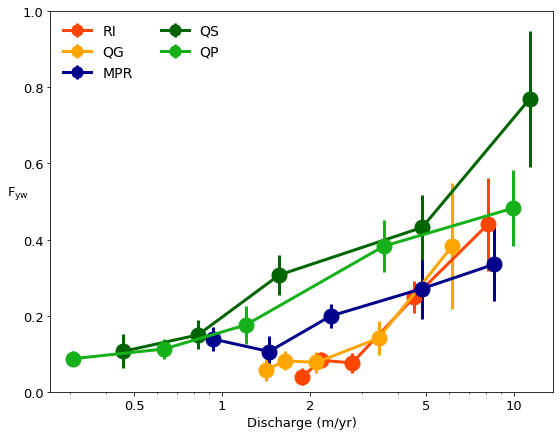

In [10]:
plt.rcParams.update({'font.size': 14})

fig3,ax3 = plt.subplots(figsize=(9,7))

for i,s in enumerate(streamsitelist2):
    tempdf = perc_outputdf.loc[perc_outputdf['site']==s,:]

    ax3.errorbar(tempdf['Qmed'],tempdf['ampratio'],yerr=tempdf['ampratio_error'],c=pp.color[s],lw=3,zorder=1,ls='-',marker='o',markersize=15)

ax3.set_xlabel('Discharge (m/yr)')
ax3.set_ylabel('F$_{\mathrm{yw}}$ ',rotation=0)

ax3.set_xscale('log')
ax3.set_xticks([0.5,1,2,5,10],['0.5','1','2','5','10'])
ax3.set_ylim([0,1])
ax3.legend(['RI','QG','MPR','QS','QP','RP'],loc='upper left',ncol=2,markerscale=0.75,frameon=False)

In [11]:
# bring in DEM analysis data
sitechars = pd.read_excel('data/WRR2025_DEManalysis.xlsx',index_col=1)
outputdf2 = outputdf.join(sitechars) # join to big dataset

## add Precipitaiton mean 
def MAP(z):
    MAPout = 1949+4.086*z-0.00148*z**2 # from Murphy 2017, in mm/yr
    return MAPout
outputdf2['Pmean'] = round(MAP(outputdf2['mean elevation']))

## add discharge mean 
wymore_watersheds = pd.read_csv('downloaded/Wymore2017Table2_watersheds.csv',index_col=0)
outputdf2 = outputdf2.merge(wymore_watersheds[['Qmean_mmyr']].rename(columns={'Qmean_mmyr':'Qmean'}),left_index=True,right_index=True,how='left')

## add q/p ratio
outputdf2['Q/P'] = outputdf2['Qmean']/outputdf2['Pmean']

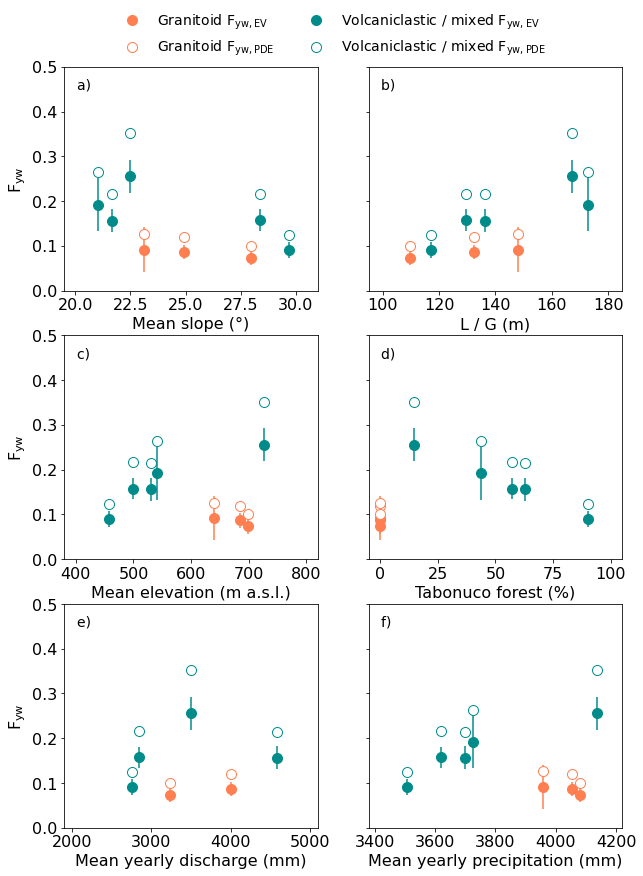

In [36]:
# begin plotting Fyw vs. different landscape characters 
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 16,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16})


plotdf = outputdf2.loc[outputdf2.index.isin(streamsitelist)]

psize=10

altcolors = ['coral','darkcyan']

paramlist = ['Slope mean','L/G','mean elevation','tabonuco','Qmean','Pmean']
paramlist_label = ['Mean slope (°)','L / G (m)','Mean elevation (m a.s.l.)','Tabonuco forest (%)','Mean yearly discharge (mm)','Mean yearly precipitation (mm)']

fig,ax = plt.subplots(3,2,figsize=(10,14),sharey=True)
ax = ax.flatten()

granitoidlist = ['RI','QG','I0'] # granitoid lithology
otherlist = ['QS','QP','RESSH','MPR','Q3'] # other 

# ratio of EV to PDE
ratio_pde_ev = outputdf.loc['EVcomp','amp']/2.5 # 2.5 per mil is reported in Scholl et al., 2015

for ip,p in enumerate(paramlist):
    for il,l in enumerate([granitoidlist,otherlist]):
        tempdf = outputdf2[outputdf2.index.isin(l)]
    
        ax[ip].errorbar(tempdf[p],tempdf['ampratio_uw'],yerr=tempdf['ampratio_uw_error'],ls='',marker='o',color=altcolors[il],markersize=psize)
        ax[ip].errorbar(tempdf[p],tempdf['ampratio_uw']*ratio_pde_ev,ls='',marker='o',color=altcolors[il],markerfacecolor='white',markersize=psize)
        ax[ip].set_xlabel(paramlist_label[ip])
        
        
        if ((p=='Pmean') & (l==otherlist)):
            # do regression
            
            res = scipy.stats.linregress(tempdf[p],tempdf['ampratio_uw'])

        
ax[0].set_ylabel('F$_{\mathrm{yw}}$')
ax[2].set_ylabel('F$_{\mathrm{yw}}$')
ax[4].set_ylabel('F$_{\mathrm{yw}}$')
        
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0],ls='', marker='o', color='coral', label='Granitoid F$_{\mathrm{yw, EV}}$',markersize=psize),
                    Line2D([0], [0],ls='', marker='o', color='coral', label='Granitoid F$_{\mathrm{yw, PDE}}$',
                          markerfacecolor='white',markersize=psize),
                    Line2D([0], [0], ls='',marker='o', color='darkcyan', label='Volcaniclastic / mixed F$_{\mathrm{yw, EV}}$',markersize=psize),
                    Line2D([0], [0], ls='',marker='o', color='darkcyan', label='Volcaniclastic / mixed F$_{\mathrm{yw, PDE}}$',
                          markerfacecolor='white',markersize=psize)]
ax[0].legend(handles=legend_elements,frameon=False,ncol=2,bbox_to_anchor=(1.95,1.3))

[ax[num].text(0.05,0.90,letters[num],transform=ax[num].transAxes) for num in range(0,6)]

ax[0].set_ylim(0,0.5)
ax[0].set_xlim([19.5,31])
ax[1].set_xlim([95,185])
ax[2].set_xlim([380,820])
ax[3].set_xlim([-5,105])
ax[4].set_xlim([1900,5100])
ax[5].set_xlim([3380,4220])

fig.savefig('plots/Fig5_Fyw.pdf')

In [13]:
# save this dataset - includes Fyw and DEM attributes, mean Q, MAP
outputdf2.to_csv('data/WRR2025_fyw_spatial.csv')

In [14]:
## Create Table 1 for paper:
table1pre = outputdf.loc[streamsitelist,['amp_uw','sterror_uw','amp','sterror','ampratio_uw','ampratio_uw_error','ampratio','ampratio_error']]
table1pre.insert(0,'numsamples',0)
table1pre.insert(0,'daterange','')

for s in table1pre.index:
    if s=='EVcomp':
        continue
    datestring = ''
    
    tempdf = luqdf[luqdf['site']==s]
    tempdf = tempdf[~np.isnan(tempdf['dexcess'])]
    
    mindate = np.nanmin(tempdf['datetime'].dt.date)
    maxdate = np.nanmax(tempdf['datetime'].dt.date)
    
    datestring = mindate.strftime('%b %Y')+' - '+maxdate.strftime('%b %Y')
    
    numsamples = len(tempdf)
    
    table1pre.loc[s,'daterange'] = datestring
    table1pre.loc[s,'numsamples'] = int(numsamples)
    

# 
precipline_ev = 'Weighted precipitation: A$_{\mathrm{p, EV}}$ = '+f'{outputdf.loc["EVcomp","amp"]:.3g} ± {outputdf.loc["EVcomp","sterror"]:.2f}' 

table1outindex = [precipline_ev,'RI','QG','I0','MPR','Q3','QS','QP','RESSH']

table1out= pd.DataFrame(index=['']+table1outindex)
table1out = table1out.merge(table1pre[['daterange','numsamples']],left_index=True,right_index=True,how='left')

secondary = ['IRLS unweighted','IRLS']
errors = ['sterror','sterror_uw']

for i,col in enumerate(['amp_uw','amp']):
    errors = ['sterror_uw','sterror']
    
    for ix in streamsitelist:
        if np.isnan(table1pre.loc[ix,col]):
            continue
        else:
            table1out.loc[ix,i] = f'{table1pre.loc[ix,col]:.2f} ± {table1pre.loc[ix,errors[i]]:.2f}'

for i,col in enumerate(['ampratio_uw','ampratio']):
    errors = ['ampratio_uw_error','ampratio_error']
    
    for ix in streamsitelist:
        if np.isnan(table1pre.loc[ix,col]):
            continue
        else:
            table1out.loc[ix,i+3] = f'{table1pre.loc[ix,col]:.2f} ± {table1pre.loc[ix,errors[i]]:.2f}'

            
table1out = table1out.fillna('')
#table1out.loc['',:] = secondary*2
table1out.columns = ['Sampling period','Sample number','d-excess A$_{\mathrm{s}}$ (‰)','','F$_{\mathrm{yw}} = \mathrm{A}_{\mathrm{s}}$/$ \mathrm{A}_{\mathrm{p}} $','']

table1out.iloc[0,:] = ['','','unweighted','weighted','unweighted','weighted']

table1out.to_csv('tables/WRR2025_table1.csv')

In [15]:
## Export tables: correlation coefficients 

precorrdf = outputdf2[['ampratio_uw','Pmean','Qmean','Q/P','mean elevation','Area','Slope mean',
        'Gmed', 'Lmed', 'L/G',  
       'inceptisol', 'oxisol', 'ultisol', 'tabonuco','palm','colorado','elfin','other']]
corrdf = precorrdf[precorrdf.index.isin(['MPR','Q3','QS','QP','RESSH'])].corr()

corrdf.to_csv('tables/WRR2025_table2a.csv')

REFERENCES

Scholl, M. A., Torres-Sanchez, A., & Rosario-Torres, M. (2014). Stable isotope (δ18O and δ2H) data for precipitation, stream water, and groundwater in Puerto Rico. US Geological Survey Open‐File Report, 1101, 2331-1258.

Scholl, M. A., & Murphy, S. F. (2014). Precipitation isotopes link regional climate patterns to water supply in a tropical mountain forest, eastern Puerto Rico. Water Resources Research, 50(5), 4305-4322.

Scholl, M. A., Shanley, J. B., Murphy, S. F., Willenbring, J. K., Occhi, M., & González, G. (2015). Stable-isotope and solute-chemistry approaches to flow characterization in a forested tropical watershed, Luquillo Mountains, Puerto Rico. Applied Geochemistry, 63, 484-497.

von Freyberg, J., Allen, S. T., Seeger, S., Weiler, M., & Kirchner, J. W. (2018). Sensitivity of young water fractions to hydro-climatic forcing and landscape properties across 22 Swiss catchments. Hydrology and Earth System Sciences, 22(7), 3841-3861.